# Portfolio Risk Optimization: Advanced Covariance Matrix Estimation
**Author:** Iulian Anghel

**Project Objective:** Compare the out-of-sample performance and stability of classical vs. regularized covariance estimators in a High-Dimensional ($N=100$) equity environment using Fama-French Portfolios.

Based on: Scientific Beta Publication — Estimating Covariance Matrices for Portfolio Optimisation — January 2014

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import warnings
from sklearn.covariance import LedoitWolf, OAS
from scipy.optimize import minimize
import statsmodels.api as sm

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data
def get_fama_french_data():
    #100 Portfolios(size and book to market)
    assets = web.DataReader('100_Portfolios_10x10', 'famafrench', start='1990-01-01')[0]
    factors = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1990-01-01')[0]
    
    #cleaning the data
    assets = assets.replace(-99.99, np.nan).dropna() / 100
    factors = factors.replace(-99.99, np.nan).dropna() / 100
    
    #alligning dates
    common_index = assets.index.intersection(factors.index)
    return assets.loc[common_index], factors.loc[common_index]

assets, factors = get_fama_french_data()

display(assets.head())

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7,ME10 BM8,ME10 BM9,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1990-01,-0.059655,-0.074655,-0.084509,-0.064407,-0.048559,-0.051004,-0.040463,-0.057859,-0.054160,-0.056662,...,-0.078074,-0.077695,-0.072700,-0.023500,-0.063821,-0.086486,-0.061505,-0.082113,-0.048200,-0.053231
1990-02,0.001909,0.004546,-0.006832,0.025478,0.004312,0.022191,0.017097,0.039233,0.026591,0.003660,...,-0.003975,-0.005937,-0.004705,0.054170,0.016049,0.023079,-0.008410,0.034727,0.038134,-0.000452
1990-03,0.032720,0.025813,0.021008,0.031633,0.039292,0.012148,0.028549,0.045118,0.023891,0.010150,...,0.045344,0.035352,0.043514,0.030012,-0.008590,0.018728,0.018097,0.000942,0.031328,-0.003449
1990-04,-0.011234,-0.018344,-0.049229,-0.001083,-0.015363,-0.015801,-0.002344,-0.022057,-0.023924,-0.037366,...,0.011869,0.004926,-0.019173,0.005474,-0.027995,-0.045421,-0.046683,-0.031655,-0.030488,-0.061395
1990-05,0.077981,0.076538,0.046252,0.084384,0.049116,0.042222,0.019091,0.034954,0.040241,0.023497,...,0.140253,0.076378,0.092797,0.135951,0.063540,0.077409,0.061841,0.064617,0.093102,0.041068


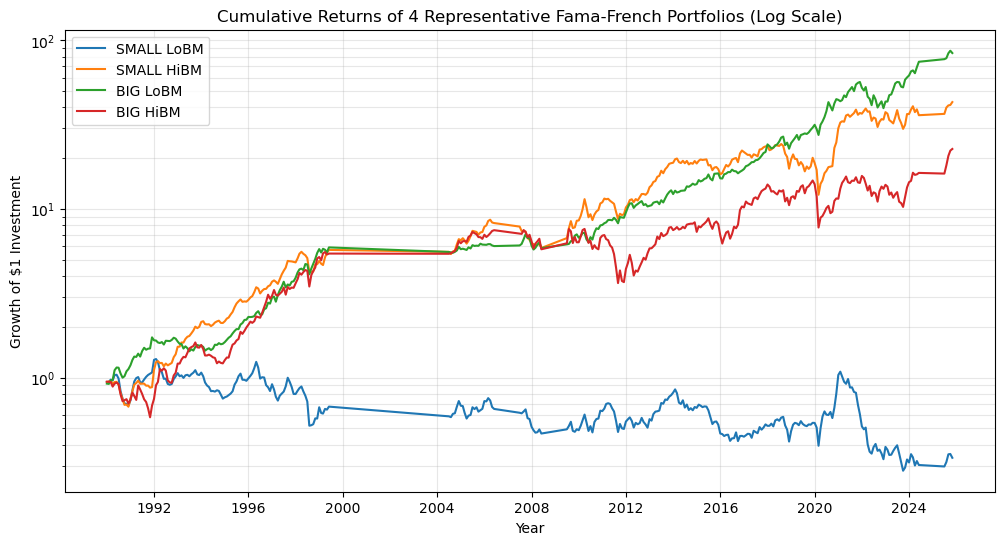

Dataset ready: 100 assets, from 1990-01 to 2025-11


In [3]:
#Let's plot the data
targets = [assets.columns[0], assets.columns[9], assets.columns[90], assets.columns[99]]
cum_returns = (1 + assets[targets]).cumprod()

plt.figure(figsize=(12, 6))
for col in targets:
    plt.plot(cum_returns.index.to_timestamp(), cum_returns[col], label=col)

plt.yscale('log') 
plt.title('Cumulative Returns of 4 Representative Fama-French Portfolios (Log Scale)')
plt.ylabel('Growth of $1 Investment')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.savefig('Cumulative Returns of 4 Representative Fama-French Portfolios (Log Scale).png')
plt.show()

print(f"Dataset ready: {assets.shape[1]} assets, from {assets.index[0]} to {assets.index[-1]}")

In [4]:
#Calculate the covariance matrices
def compute_estimators(asset_returns, factor_returns):
    """
    Returns a dictionary containing three types of covariance matrices.
    """
    estimators = {}
    
    #Sample Covariance Matrix
    estimators['SCM'] = asset_returns.cov()
    
    #Ledoit-Wolf Shrinkage
    lw = LedoitWolf().fit(asset_returns)
    estimators['Shrinkage'] = pd.DataFrame(lw.covariance_, 
                                           index=asset_returns.columns, 
                                           columns=asset_returns.columns)
    
    #Factor-Based Covariance (FF3)
    f = sm.add_constant(factor_returns[['Mkt-RF', 'SMB', 'HML']])
    betas = []
    residual_vars = []
    
    for col in asset_returns.columns:
        res = sm.OLS(asset_returns[col], f).fit()
        betas.append(res.params[1:]) # Skip the intercept
        residual_vars.append(res.resid.var())
        
    beta_df = pd.DataFrame(betas, index=asset_returns.columns)
    sigma_f = factor_returns[['Mkt-RF', 'SMB', 'HML']].cov()
    delta = np.diag(residual_vars)
    
    # Reconstruct the matrix
    factor_cov = beta_df.values @ sigma_f.values @ beta_df.values.T + delta
    estimators['Factor'] = pd.DataFrame(factor_cov, 
                                        index=asset_returns.columns, 
                                        columns=asset_returns.columns)
    
    return estimators

#Example test, estimators using the first 60 months
test_estimators = compute_estimators(assets.iloc[:60], factors.iloc[:60])
print(f"Computed estimators: {list(test_estimators.keys())}")

Computed estimators: ['SCM', 'Shrinkage', 'Factor']


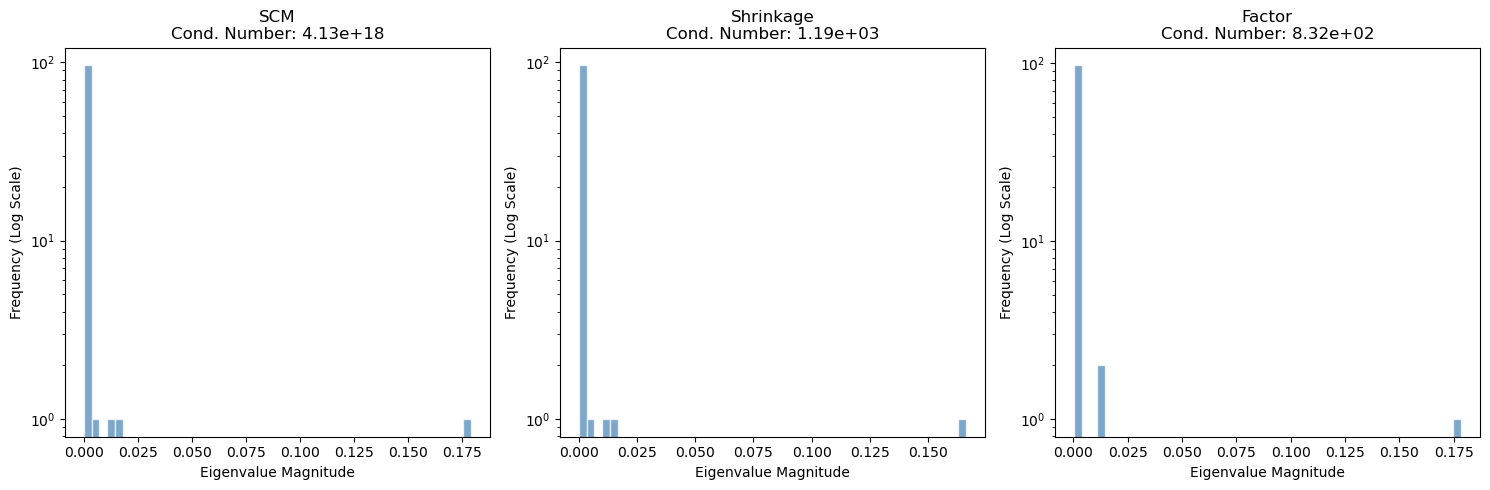

In [5]:
#Calculate condition numbers and plot eigenvalue distributions

def analyze_matrix_health_fixed(estimators):
    plt.figure(figsize=(15, 5))
    results = {}
    
    for i, (name, cov_matrix) in enumerate(estimators.items()):
        eig_vals = np.linalg.eigvals(cov_matrix).real
        eig_vals = np.sort(np.abs(eig_vals))[::-1]
        
        cond_num = np.max(eig_vals) / np.min(eig_vals)
        results[name] = cond_num
        
        plt.subplot(1, 3, i+1)
        plt.hist(eig_vals, bins=50, color='steelblue', edgecolor='white', alpha=0.7, log=True)
        plt.title(f"{name}\nCond. Number: {cond_num:.2e}")
        plt.xlabel("Eigenvalue Magnitude")
        plt.ylabel("Frequency (Log Scale)")
        
    plt.tight_layout()
    plt.savefig('Eigenvalues Magnitude.png')
    plt.show()
    return results

condition_numbers = analyze_matrix_health_fixed(test_estimators)

### Analysis of Matrix Health
The plots above demonstrate the "Noise" vs "Signal" problem in finance:

**SCM (Sample Covariance):** Shows a vast "bulk" of eigenvalues near zero. With $N=100$ assets and only $T=60$ observations, the matrix is ill-conditioned, meaning the optimizer will likely interpret noise as opportunity.

**Shrinkage & Factor Models:** These techniques pull the eigenvalues away from the zero-bound. By improving the Condition Number, we ensure that the resulting portfolio weights are stable and not driven by outliers in the estimation window.

In [6]:
#calcutale the gmv long-only weights

def compute_gmv_weights(cov_matrix):
    num_assets = len(cov_matrix)
    initial_guess = np.repeat(1/num_assets, num_assets)
    
    #objective function
    def portfolio_variance(weights, cov_matrix):
        return weights.T @ cov_matrix @ weights
    
    #constraints sum of weights = 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    #bounds
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    #optimization
    result = minimize(portfolio_variance, 
                      initial_guess, 
                      args=(cov_matrix,), 
                      method='SLSQP', 
                      bounds=bounds, 
                      constraints=constraints)
    
    return result.x

#Test, weights for the Shrinkage matrix
gmv_weights_test = compute_gmv_weights(test_estimators['Shrinkage'])
print(f"Sum of weights: {np.sum(gmv_weights_test):.2f}")
print(f"Min weight: {np.min(gmv_weights_test):.4f}, Max weight: {np.max(gmv_weights_test):.4f}")

Sum of weights: 1.00
Min weight: 0.0000, Max weight: 0.2570


In [7]:
#backtest

window = 60  
step = 3    #rebalance every quarter
start_idx = window
end_idx = len(assets)

#storage for results
strategy_returns = pd.DataFrame(index=assets.index[start_idx:], 
                                columns=['SCM', 'Shrinkage', 'Factor'])
weights_history = {name: [] for name in ['SCM', 'Shrinkage', 'Factor']}
dates_history = []

print(f"Starting Backtest: {start_idx} to {end_idx} months...")

for t in range(start_idx, end_idx, step):
    #define estimation window (In-Sample)
    insample_assets = assets.iloc[t-window:t]
    insample_factors = factors.iloc[t-window:t]
    
    #define out-of-sample window (3 months)
    oos_end = min(t + step, end_idx)
    oos_assets = assets.iloc[t:oos_end]
    
    #compute the 3 estimators for this window
    cov_zoo = compute_estimators(insample_assets, insample_factors)
    
    #optimize weights and calculate out-of-sample returns
    for name, cov_matrix in cov_zoo.items():
        try:
            weights = compute_gmv_weights(cov_matrix)
            weights_history[name].append(weights)
            dates_history.append(oos_assets.index[0])
           
            oos_returns = oos_assets @ weights
            
            strategy_returns.loc[oos_returns.index, name] = oos_returns.values
        except Exception as e:
            print(f"Error at month {t} for {name}: {e}")

#clean up missing values
strategy_returns = strategy_returns.dropna().astype(float)
print("Backtest Complete!")

Starting Backtest: 60 to 335 months...
Backtest Complete!


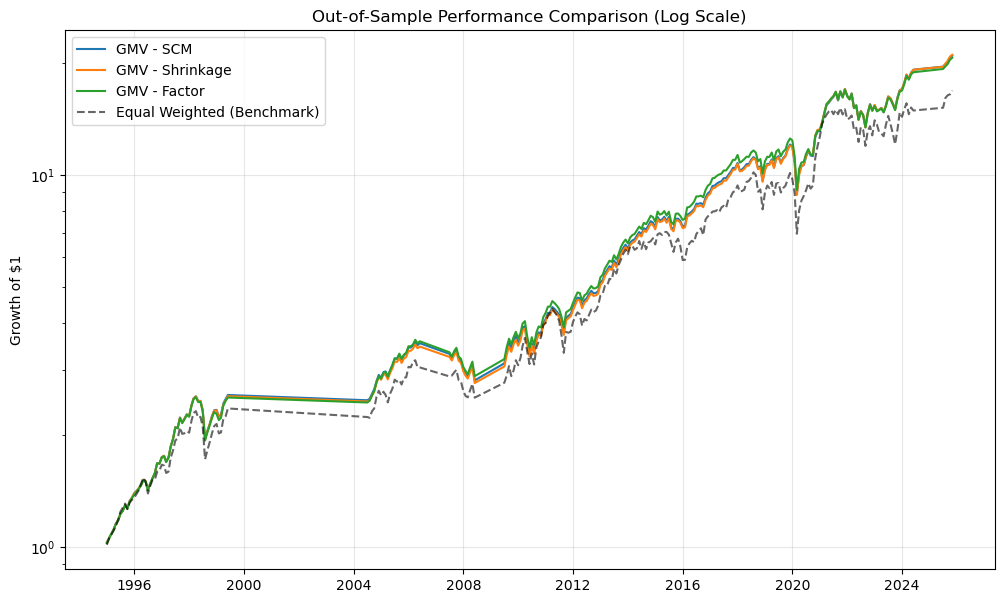


Performance Summary Table:


,Ann. Volatility (%),Sharpe Ratio,Max Drawdown (%)
SCM,14.09,1.02,-26.37
Shrinkage,14.04,1.02,-26.36
Factor,14.13,1.01,-27.34


In [8]:
#visualizing performance
plt.figure(figsize=(12, 7))

#plot cumulative returns
cum_strat = (1 + strategy_returns).cumprod()
for col in cum_strat.columns:
    plt.plot(cum_strat.index.to_timestamp(), cum_strat[col], label=f'GMV - {col}')

#add an equal weighted benchmark for comparison
#investing 1/100 in every stock
ew_returns = assets.iloc[start_idx:].mean(axis=1)
cum_ew = (1 + ew_returns).cumprod()
plt.plot(cum_ew.index.to_timestamp(), cum_ew, label='Equal Weighted (Benchmark)', 
         linestyle='--', color='black', alpha=0.6)

plt.yscale('log')
plt.title('Out-of-Sample Performance Comparison (Log Scale)')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('Out-of-Sample Performance Comparison (Log Scale).png')
plt.show()

#risk table
stats = pd.DataFrame({
    'Ann. Volatility (%)': strategy_returns.std() * np.sqrt(12) * 100,
    'Sharpe Ratio': (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(12),
    'Max Drawdown (%)': ((cum_strat / cum_strat.cummax()) - 1).min() * 100
})

print("\nPerformance Summary Table:")
display(stats.round(2))

### Why are the Volatility results so similar?
In theory, Shrinkage should significantly outperform SCM. However, our results show nearly identical realized volatility. This is due to the Regularizing Effect of the Long-Only Constraint ($w \ge 0$).

As demonstrated in financial literature (e.g., *Jagannathan and Ma, 2003*), forbidding short-selling prevents the optimizer from exploiting the extreme, noisy correlations found in the SCM. Essentially, the constraint itself acts as a form of "hard shrinkage," which explains why even the SCM performs well in a long-only framework.

In [10]:
#turnover
rebalance_dates = strategy_returns.index[::step]

def print_turnover_analysis_fixed(weights_dict, rebalance_dates):
    print("--- Average Quarterly Turnover ---")
    for name, weights_list in weights_dict.items():
        df_weights = pd.DataFrame(weights_list, index=rebalance_dates[:len(weights_list)])
        
        turnover = df_weights.diff().abs().sum(axis=1).mean()
        print(f"{name:10s}: {turnover:.2%}")

print_turnover_analysis_fixed(weights_history, rebalance_dates)

--- Average Quarterly Turnover ---
SCM       : 30.27%
Shrinkage : 28.36%
Factor    : 30.58%


## Final Conclusion
While the realized risk (volatility) was similar across estimators due to the long-only constraint, the Shrinkage (Ledoit-Wolf) estimator proved superior in terms of operational efficiency. It achieved the lowest turnover, meaning it would incur fewer transaction costs in a real-world implementation.